In [1]:
import csv, re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
video_user = {}
with open('../../datas/StatLearning_Filtered_IndividualProfile.csv','r') as csvfile :
    lines = csv.reader(csvfile, delimiter = ',', quotechar = '"')
    count = 0
    for line in lines :
        count+= 1
        if line == ['videoId', 'second', 'numViews']:
            continue
        else:
            videoID,userID,second,numViews = line

            if videoID not in video_user:
                video_user[videoID] = {}
                
            if userID not in video_user[videoID]:
                video_user[videoID][userID] = {}
                video_user[videoID][userID]['time'] = [int(second)]
                video_user[videoID][userID]['views'] = [int(numViews)]
            else:
                video_user[videoID][userID]['time'].append(int(second))
                video_user[videoID][userID]['views'].append(int(numViews))
        if count % 5000000 == 0:
            print count

5000000
10000000
15000000
20000000
25000000
30000000
35000000
40000000
45000000
50000000
55000000
60000000


In [2]:
# get user video dict
userVideoTime = {}
for video in video_user:
    for user in video_user[video]:
        if user not in userVideoTime:
            userVideoTime[user] = {}
        userDict = userVideoTime[user]
        if video not in userDict:
            userDict[video] = 0
        userDict[video] += sum(video_user[video][user]['views'])

In [ ]:
# export user video time
f = open("../../stats_data/UserVideoTime.csv", "w")
for user in userVideoTime:
    for video in userVideoTime[user]:
        line = str(user) + "," + str(video) + "," + str(userVideoTime[user][video]) + "\n"
        f.write(line)
f.close()

In [3]:
print video_user.keys()

['i4x-HumanitiesSciences-StatLearning-video-4ebc550ec53646b0a7523c18f4638f70', 'i4x-HumanitiesSciences-StatLearning-video-40e9c1b8c5124a41bc2c1c6c0fd0f629', 'i4x-HumanitiesSciences-StatLearning-video-c2c1c6df5f8a4eac95132a7eaaa72193', 'i4x-HumanitiesSciences-StatLearning-video-e6b6e7f1c8964a45ba6651c6b0f91674', 'i4x-HumanitiesSciences-StatLearning-video-a44691b3b90842d9bb595b77606d45ad', 'i4x-HumanitiesSciences-StatLearning-video-067c5fe85e46492b94502c24e45672f2', 'i4x-HumanitiesSciences-StatLearning-video-3b3df179eb1d4046bd7ca889028a936c', 'i4x-HumanitiesSciences-StatLearning-video-10ba326892c548589a123f1366226510', 'i4x-HumanitiesSciences-StatLearning-video-6ff20d54d7bb40f9880d5e30ba63adbf', 'i4x-HumanitiesSciences-StatLearning-video-fdb4cff53e2b40499545468428511e44', 'i4x-HumanitiesSciences-StatLearning-video-c492f147880c472eb6fb64d535b3a4eb', 'i4x-HumanitiesSciences-StatLearning-video-ff8a9142c9374748ba2a336ba0cdd40a', 'i4x-HumanitiesSciences-StatLearning-video-93561fcfddeb4a2ab43e

In [4]:
videoProfile = {}
for videoId in video_user:
    maxTime = 0
    for user in video_user[videoId]:
        maxTime = max(maxTime, max(video_user[videoId][user]['time']))
    times = [0] * maxTime
    for user in video_user[videoId]:
        keys = video_user[videoId][user]['time']
        vals = video_user[videoId][user]['views']
        for i in range(len(keys)):
            key = keys[i]-1
            val = vals[i]
            times[key] += val
    videoProfile[videoId] = times

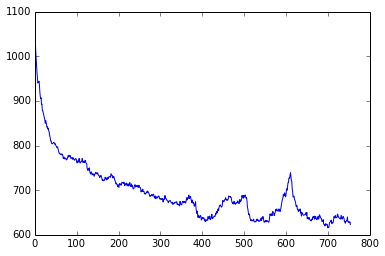

In [5]:
videoId = 'i4x-HumanitiesSciences-StatLearning-video-e77fcb7f9d0b467cac7e4659fa270191'
# print videoProfile[videoId]
plt.plot(range(len(videoProfile[videoId])-2), videoProfile[videoId][:-2])

In [8]:
import math
import numpy as np
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest

    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.

    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

def find_peak(c):
	windows = []
	mean = c[0]
	p = 5
	tao = 2.4
	meandev = math.sqrt(np.var(c[:p]))

	for i in range(1, len(c)):
		if math.fabs(c[i] - mean)/meandev > tao and c[i] > c[i-1]:
			start = i-1
			while i < len(c) and c[i] > c[i-1]:
				(mean, meandev) = update(mean, meandev, c[i])
				i += 1
			end = start
			while i < len(c) and c[i] > c[start]:
				if math.fabs(c[i] - mean)/meandev > tao and c[i] > c[i-1]:
					i -= 1
					end = i
					break
				else:
					(mean, meandev) = update(mean, meandev, c[i])
					end = i
					i += 1
			windows.append((start, end))
		else:
			(mean, meandev) = update(mean, meandev, c[i])

	return windows

def update(oldmean, oldmeandev, updatevalue):
	alpha = 0.125
	diff = math.fabs(oldmean - updatevalue)
	newmeandev = alpha*diff + (1-alpha)*oldmeandev
	newmean = alpha*updatevalue + (1-alpha)*oldmean
	return (newmean, newmeandev)


def peak_to_plot(w, leng, val=100):
	ret = [0] * leng
	for window in w:
		start = window[0]
		end = window[1]
		if start > end:
			temp = start
			start = end
			end = temp
		for i in range(start, end):
			ret[i] = val
	return ret

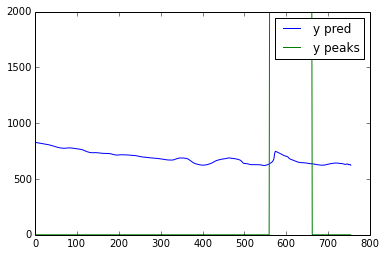

In [10]:

x = range(len(videoProfile[videoId])-2)
y = videoProfile[videoId][:-2]

x = np.asarray(x)
y = np.asarray(y)

f = 0.15
yest = lowess(x, y, f=f, iter=3)

w = find_peak(yest)
yplots = peak_to_plot(w, len(y), 2000)

import pylab as pl
pl.clf()
# pl.plot(x, y, label='y noisy')
pl.plot(x, yest, label='y pred')
pl.plot(x, yplots, label='y peaks')
pl.legend()
pl.show()


In [13]:
# get user video peak percentage
userVideoPeakPercentage = {}
count = 0
for videoId in video_user:
    
    x = range(len(videoProfile[videoId])-2)
    y = videoProfile[videoId][:-2]

    x = np.asarray(x)
    y = np.asarray(y)

    f = 0.15
    try:
        yest = lowess(x, y, f=f, iter=3)

        w = find_peak(yest)
        yplots = peak_to_plot(w, len(y), 2000)
    except:
        yplots = [0] * len(y)
        
    peak_number = 0
    for i in range(len(yplots)):
        if yplots[i] > 0: #peak
            peak_number += 1
            
    count += 1
    if count % 10 == 0:
        print count
    
    for user in video_user[videoId]:
        if user not in userVideoPeakPercentage:
            userVideoPeakPercentage[user] = {}
        userDict = userVideoPeakPercentage[user]
        if videoId not in userDict:
            userDict[videoId] = 0
            
            peak_total = 0.0
            
            keys = video_user[videoId][user]['time']
            vals = video_user[videoId][user]['views']
            for i in range(len(keys)):
                key = keys[i]-1
                val = vals[i]
                if key < len(yplots) and yplots[key] > 0: #peak
                    peak_total += val
            
            
                    
            peak_percent = 0
            if peak_number > 0:
                peak_percent = peak_total / peak_number
            
            userDict[videoId] = peak_percent
            
print "finished"

10
20
30
40
50
60
70
finished


In [15]:
# export user video peak percentage
f = open("../../stats_data/UserVideoPeakPercentage.csv", "w")
for user in userVideoPeakPercentage:
    for video in userVideoPeakPercentage[user]:
        line = str(user) + "," + str(video) + "," + str(userVideoPeakPercentage[user][video]) + "\n"
        f.write(line)
f.close()